In [3]:
import pandas as pd
import numpy as np 
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt 

In [4]:
btc_data = yf.download('BTC-USD', start='2017-01-01', end='2022-01-01')
btc_df = pd.DataFrame(btc_data)

[*********************100%***********************]  1 of 1 completed


In [5]:
btc_df = btc_df.drop(columns=['Adj Close', 'Volume', 'High', 'Low', 'Open'])

In [6]:
btc_df.head()

,Close
Date,
2017-01-01,998.325012
2017-01-02,1021.750000
2017-01-03,1043.839966
2017-01-04,1154.729980
2017-01-05,1013.380005


In [7]:
short_window = 8
long_window = 21

In [8]:
btc_df['SMA8'] = btc_df['Close'].rolling(window=short_window).mean()
btc_df['SMA21'] = btc_df['Close'].rolling(window=long_window).mean()

In [9]:
btc_df.head()

,Close,SMA8,SMA21
Date,,,
2017-01-01,998.325012,NaN,NaN
2017-01-02,1021.750000,NaN,NaN
2017-01-03,1043.839966,NaN,NaN
2017-01-04,1154.729980,NaN,NaN
2017-01-05,1013.380005,NaN,NaN


In [10]:
btc_df['Signal'] = 0.0
btc_df = btc_df.dropna()

In [11]:
btc_df['Signal'][short_window:] = np.where(
    btc_df['SMA8'][short_window:] > btc_df['SMA21'][short_window:], 1.0, 0.0
)

In [12]:
# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
btc_df['Entry/Exit'] = btc_df['Signal'].diff()

# Review the DataFrame
btc_df.tail(10)

,Close,SMA8,SMA21,Signal,Entry/Exit
Date,,,,,
2021-12-23,50784.539062,47831.663086,48725.319754,0.0,0.0
2021-12-24,50822.195312,48226.259277,48593.126860,0.0,0.0
2021-12-25,50429.859375,48754.723633,48651.658110,1.0,1.0
2021-12-26,50809.515625,49249.815918,48720.261347,1.0,0.0
2021-12-27,50640.417969,49741.491211,48723.013393,1.0,0.0
2021-12-28,47588.855469,49830.063477,48574.859561,1.0,0.0
2021-12-29,46444.710938,49518.575684,48381.522135,1.0,0.0
2021-12-30,47178.125000,49337.277344,48357.998512,1.0,0.0
2021-12-31,46306.445312,48777.515625,48313.386161,1.0,0.0


In [13]:
# Filling missing values with the previous ones
btc_df = btc_df.fillna(method ='pad')

In [14]:
btc_rnn = btc_df[['Close']]
btc_rnn

,Close
Date,
2017-01-21,921.789001
2017-01-22,924.672974
2017-01-23,921.012024
2017-01-24,892.687012
2017-01-25,901.541992
...,...
2021-12-28,47588.855469
2021-12-29,46444.710938
2021-12-30,47178.125000


In [15]:
 def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [16]:
btc_rnn.isnull().sum()

Close    0
dtype: int64

In [17]:
# Define the window size
window_size = 30

# Set the index of the feature and target columns
feature_column = 0
target_column = 0

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(btc_rnn, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[ 921.78900146  924.67297363  921.01202393  892.68701172  901.54199219
   917.58599854  919.75        921.59002686  919.49597168  920.38201904
   970.40301514  989.02301025 1011.79998779 1029.91003418 1042.90002441
  1027.33996582 1038.15002441 1061.34997559 1063.06994629  994.38299561
   988.67401123 1004.45001221  999.18103027  990.64202881 1004.54998779
  1007.47998047 1027.43994141 1046.20996094 1054.42004395 1047.86999512]
 [ 924.67297363  921.01202393  892.68701172  901.54199219  917.58599854
   919.75        921.59002686  919.49597168  920.38201904  970.40301514
   989.02301025 1011.79998779 1029.91003418 1042.90002441 1027.33996582
  1038.15002441 1061.34997559 1063.06994629  994.38299561  988.67401123
  1004.45001221  999.18103027  990.64202881 1004.54998779 1007.47998047
  1027.43994141 1046.20996094 1054.42004395 1047.86999512 1079.97998047]
 [ 921.01202393  892.68701172  901.54199219  917.58599854  919.75
   921.59002686  919.49597168  920.38201904  970.40

In [18]:
 # Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [19]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [20]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[1.56422672e-03]
  [1.71923970e-03]
  [1.52246431e-03]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [1.36736800e-05]
  [1.12717513e-04]
  [0.00000000e+00]
  [0.00000000e+00]
  [1.77172454e-03]
  [2.77496351e-03]
  [4.00217926e-03]
  [4.97794236e-03]
  [5.67783858e-03]
  [4.83946795e-03]
  [5.42191021e-03]
  [6.67191564e-03]
  [6.76458707e-03]
  [3.06375768e-03]
  [2.75615956e-03]
  [3.60616509e-03]
  [3.32227415e-03]
  [2.86219567e-03]
  [3.61155174e-03]
  [3.76941874e-03]
  [4.84485460e-03]
  [5.85617683e-03]
  [6.29853329e-03]
  [5.94561890e-03]]

 [[1.71923970e-03]
  [1.52246431e-03]
  [0.00000000e+00]
  [4.75953609e-04]
  [8.62773097e-04]
  [1.16470564e-04]
  [1.12717513e-04]
  [0.00000000e+00]
  [4.76936119e-05]
  [2.69262780e-03]
  [2.77496351e-03]
  [4.00217926e-03]
  [4.97794236e-03]
  [5.67783858e-03]
  [4.83946795e-03]
  [5.42191021e-03]
  [6.67191564e-03]
  [6.76458707e-03]
  [3.06375768e-03]
  [2.75615956e-03]
  [3.60616509e-03]
  [3.3

In [21]:
 # Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [22]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [23]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [24]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")
# Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 30)            3840      
                                                                 
 dropout (Dropout)           (None, 30, 30)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 30)            7320      
                                                                 
 dropout_1 (Dropout)         (None, 30, 30)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [25]:
 # Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Epoch 1/10
14/14 [==============================] - 13s 56ms/step - loss: 0.0497
Epoch 2/10
14/14 [==============================] - 1s 53ms/step - loss: 0.0182
Epoch 3/10
14/14 [==============================] - 1s 56ms/step - loss: 0.0100
Epoch 4/10
14/14 [==============================] - 1s 56ms/step - loss: 0.0073
Epoch 5/10
14/14 [==============================] - 1s 58ms/step - loss: 0.0065
Epoch 6/10
14/14 [==============================] - 1s 56ms/step - loss: 0.0060
Epoch 7/10
14/14 [==============================] - 1s 54ms/step - loss: 0.0056
Epoch 8/10
14/14 [==============================] - 1s 55ms/step - loss: 0.0054
Epoch 9/10
14/14 [==============================] - 1s 53ms/step - loss: 0.0054
Epoch 10/10
14/14 [==============================] - 1s 56ms/step - loss: 0.0050


In [26]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

1.0205754041671753

In [27]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [28]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [29]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = btc_rnn.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.head()

,Actual,Predicted
Date,,
2020-07-17,9151.392578,9272.088867
2020-07-18,9159.040039,9273.632812
2020-07-19,9185.817383,9273.267578
2020-07-20,9164.231445,9271.127930
2020-07-21,9374.887695,9268.080078


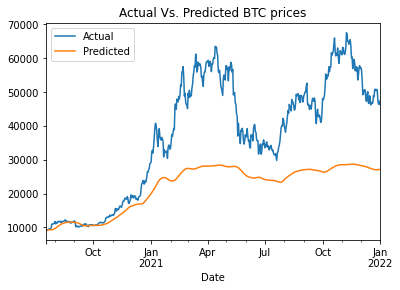

In [30]:
 # Plot the real vs predicted prices as a line chart
stocks.plot(title="Actual Vs. Predicted BTC prices")